In [2]:
!pip install torchdiffeq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 108.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 81.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 82.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [3]:
# Import libraries
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torchdiffeq import odeint


In [60]:
# Load data
file_path = 'combined_data.csv'  # <- replace if necessary
data = pd.read_csv(file_path)

# Preprocess
# Average monthly data into yearly
yearly_data = data.groupby('year').mean().reset_index()
time = yearly_data['year'].values
eagle_pop = yearly_data['bald_eagle_count'].values
osprey_pop = yearly_data['osprey_count'].values
salmon_pop = yearly_data['runsize'].values / 1e6  # Scale down
#salmon_pop = yearly_data['spawners'].values / 1e6


In [61]:
# CALCULATE R* FOR MECHANISTIC MODEL
# Parameters
d = 0.1  # death rate

# Estimate growth rates
eagle_growth_rate = np.gradient(eagle_pop)
osprey_growth_rate = np.gradient(osprey_pop)
resource = salmon_pop.copy()
#resource[resource == 0] = 1e-6  # Avoid divide by zero

# Estimate a_j
a_eagle_est = np.mean((eagle_growth_rate / eagle_pop + d) / resource)
a_osprey_est = np.mean((osprey_growth_rate / osprey_pop + d) / resource)

# R* calculation
R_star_eagle = d / a_eagle_est
R_star_osprey = d / a_osprey_est

print("\n--- R* Results ---")
print(f"Bald Eagle R*: {R_star_eagle:.3f}")
print(f"Osprey R*: {R_star_osprey:.3f}")



--- R* Results ---
Bald Eagle R*: 0.369
Osprey R*: 0.395


In [54]:
# Normalize for Neural ODE
# Set noise level (as a fraction of the signal's standard deviation)
noise_level = 0.05  # 5% noise

# Add noise to each species separately
eagle_noisy = eagle_pop + np.random.normal(0, noise_level * np.std(eagle_pop), size=eagle_pop.shape)
osprey_noisy = osprey_pop + np.random.normal(0, noise_level * np.std(osprey_pop), size=osprey_pop.shape)
#salmon_noisy = salmon_pop + np.random.normal(0, noise_level * np.std(salmon_pop), size=salmon_pop.shape)

# Normalize the noisy data
eagle_norm = (eagle_noisy - np.mean(eagle_noisy)) / np.std(eagle_noisy)
osprey_norm = (osprey_noisy - np.mean(osprey_noisy)) / np.std(osprey_noisy)
#salmon_norm = (salmon_noisy - np.mean(salmon_noisy)) / np.std(salmon_noisy)
'''eagle_norm = (eagle_pop - np.mean(eagle_pop)) / np.std(eagle_pop)
osprey_norm = (osprey_pop - np.mean(osprey_pop)) / np.std(osprey_pop) '''
salmon_norm = (salmon_pop - np.mean(salmon_pop)) / np.std(salmon_pop)
#salmon_norm = salmon_pop

y_data = torch.tensor(np.stack([eagle_norm, osprey_norm, salmon_norm], axis=1), dtype=torch.float32)
t_data = torch.tensor(np.linspace(0, 1, len(time)), dtype=torch.float32)

# Define Neural ODE Model
class ODEFunc(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(3, 50),
            nn.Tanh(),
            nn.Linear(50, 3)
        )

    def forward(self, t, y):
        return self.net(y)

# Instantiate model and optimizer
func = ODEFunc()
optimizer = torch.optim.Adam(func.parameters(), lr=1e-3)
y0 = y_data[0]

# Train Neural ODE
n_epochs = 3000
for epoch in range(n_epochs):
    pred_y = odeint(func, y0, t_data)
    loss = torch.mean((pred_y - y_data)**2)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 500 == 0:
        print(f"Epoch {epoch} Loss {loss.item():.6f}")

# Predict and Unnormalize
pred_y = odeint(func, y0, t_data).detach().numpy()
eagle_pred = pred_y[:,0] * np.std(eagle_pop) + np.mean(eagle_pop)
osprey_pred = pred_y[:,1] * np.std(osprey_pop) + np.mean(osprey_pop)
salmon_pred = pred_y[:,2] * np.std(salmon_pop) + np.mean(salmon_pop)


Epoch 0 Loss 1.742970
Epoch 500 Loss 0.336987
Epoch 1000 Loss 0.317681
Epoch 1500 Loss 0.310514
Epoch 2000 Loss 0.305303
Epoch 2500 Loss 0.302703


In [58]:
#eagle_norm, osprey_norm, salmon_norm

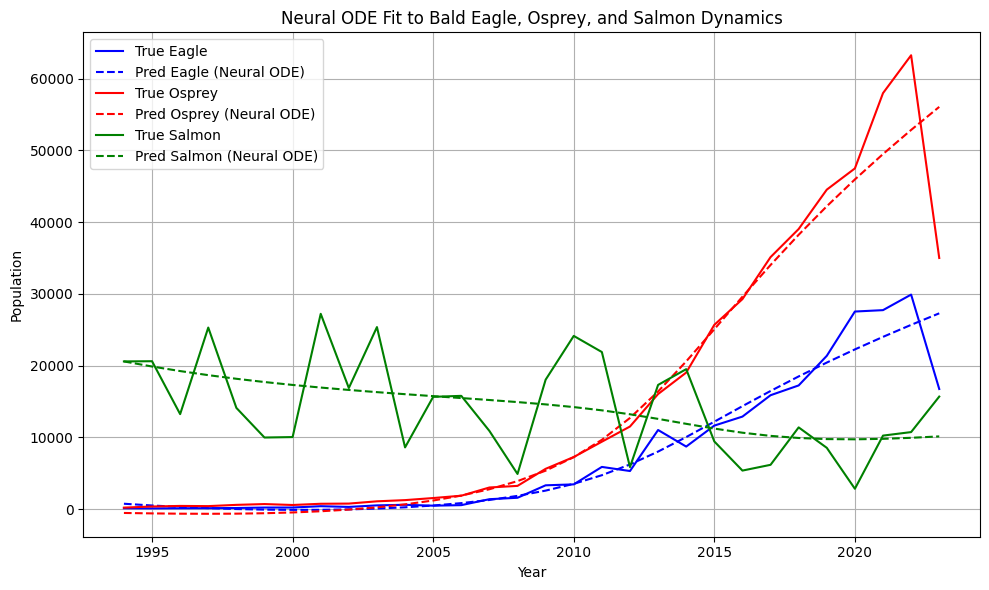

In [55]:
# Plot Results
plt.figure(figsize=(10,6))
plt.plot(time, eagle_pop, 'b-', label='True Eagle')
plt.plot(time, eagle_pred, 'b--', label='Pred Eagle (Neural ODE)')
plt.plot(time, osprey_pop, 'r-', label='True Osprey')
plt.plot(time, osprey_pred, 'r--', label='Pred Osprey (Neural ODE)')
plt.plot(time, salmon_pop * 1e4, 'g-', label='True Salmon')
plt.plot(time, salmon_pred * 1e4, 'g--', label='Pred Salmon (Neural ODE)')
plt.legend()
plt.title("Neural ODE Fit to Bald Eagle, Osprey, and Salmon Dynamics")
plt.xlabel("Year")
plt.ylabel("Population")
plt.grid(True)
plt.tight_layout()
plt.show()


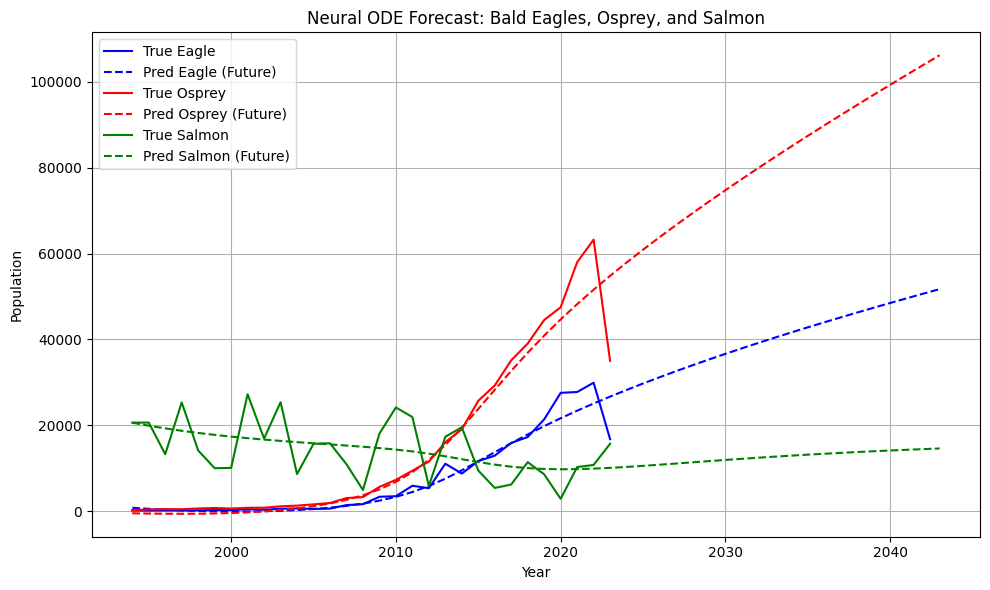

In [56]:
# FORECASTING

# Step 1: Create a new longer time vector
n_future_years = 20  # Predict 20 years into the future
t_future = torch.linspace(0, 1 + n_future_years / len(time), len(time) + n_future_years)

# Step 2: Predict using the trained Neural ODE
with torch.no_grad():
    pred_future = odeint(func, y0, t_future)

# Step 3: Unnormalize the predictions
eagle_future = pred_future[:,0].numpy() * np.std(eagle_pop) + np.mean(eagle_pop)
osprey_future = pred_future[:,1].numpy() * np.std(osprey_pop) + np.mean(osprey_pop)
salmon_future = pred_future[:,2].numpy() * np.std(salmon_pop) + np.mean(salmon_pop)

# Step 4: Create a corresponding time axis
start_year = time[0]
end_year = time[-1]
year_spacing = (end_year - start_year) / (len(time) - 1)
future_years = np.linspace(start_year, end_year + n_future_years * year_spacing, len(time) + n_future_years)

# Step 5: Plot
plt.figure(figsize=(10,6))
plt.plot(yearly_data['year'], eagle_pop, 'b-', label='True Eagle')
plt.plot(future_years, eagle_future, 'b--', label='Pred Eagle (Future)')
plt.plot(yearly_data['year'], osprey_pop, 'r-', label='True Osprey')
plt.plot(future_years, osprey_future, 'r--', label='Pred Osprey (Future)')
plt.plot(yearly_data['year'], salmon_pop*1e4, 'g-', label='True Salmon')
plt.plot(future_years, salmon_future*1e4, 'g--', label='Pred Salmon (Future)')
plt.legend()
plt.title("Neural ODE Forecast: Bald Eagles, Osprey, and Salmon")
plt.xlabel("Year")
plt.ylabel("Population")
plt.grid(True)
plt.tight_layout()
plt.show()


In [32]:
fish_df = pd.read_csv('fishdata.csv')
fish_df

,Unnamed: 0,species,year,spawners,runsize
0,12,Chinook,1994,64912.91,193971.24
1,13,Chinook,1995,71115.11,217203.54
2,14,Chinook,1996,77020.35,196012.28
3,15,Chinook,1997,84339.29,199952.77
4,16,Chinook,1998,35965.82,97281.46
...,...,...,...,...,...
1225,2520,Steelhead,2019,34.00,NaN
1226,2521,Steelhead,2020,24.00,NaN
1227,2522,Steelhead,2021,1.00,NaN
1228,2523,Steelhead,2022,9.00,NaN


In [73]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchdiffeq

# Define the Neural ODE with ecological structure
class ResourceCompetitionODE(nn.Module):
    def __init__(self):
        super(ResourceCompetitionODE, self).__init__()

        # Parameters to learn
        self.a_eagle = nn.Parameter(torch.tensor([0.01]))  # eagle consumption efficiency
        self.a_osprey = nn.Parameter(torch.tensor([0.01])) # osprey consumption efficiency
        self.d = nn.Parameter(torch.tensor([0.01]))         # common death rate
        self.r = nn.Parameter(torch.tensor([0.1]))         # salmon replenishment rate

    def forward(self, t, y):
        eagle, osprey, salmon = y

        deagle_dt = eagle * (self.a_eagle * salmon - self.d)
        dosprey_dt = osprey * (self.a_osprey * salmon - self.d)
        dsalmon_dt = self.r - salmon * (self.a_eagle * eagle + self.a_osprey * osprey)

        return torch.cat([deagle_dt, dosprey_dt, dsalmon_dt])


time_points = torch.linspace(0, len(time) - 1, steps=len(eagle_pop))

# Normalize the data separately for each species
eagle_norm = (eagle_pop - eagle_pop.mean()) / eagle_pop.std()
osprey_norm = (osprey_pop - osprey_pop.mean()) / osprey_pop.std()
salmon_norm = (salmon_pop - salmon_pop.mean()) / salmon_pop.std()

# Stack into tensor (shape: [time, features])
population_data = torch.tensor(np.stack([eagle_norm, osprey_norm, salmon_norm], axis=1), dtype=torch.float32)

# Set up the ODE system
ode_func = ResourceCompetitionODE()

# Optimizer
optimizer = optim.Adam(ode_func.parameters(), lr=0.01)

# Training loop
n_epochs = 2000
loss_history = []

for epoch in range(n_epochs):
    optimizer.zero_grad()

    # Initial condition
    y0 = population_data[0]

    # Predict the entire time series
    pred_y = torchdiffeq.odeint(ode_func, y0, time_points,
                               method='dopri5',
                               options={'step_size': 0.1}) # Adjust step size if needed

    #pred_y = torchdiffeq.odeint(ode_func, y0, time_points)

    # Compute loss (Mean Squared Error)
    loss = torch.mean((pred_y - population_data)**2)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(ode_func.parameters(), 1.0)

    optimizer.step()

    loss_history.append(loss.item())

    if epoch % 500 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item():.6f}')

# After training, the learned parameters are:
print("\nLearned parameters:")
print(f"a_eagle: {ode_func.a_eagle.item():.4f}")
print(f"a_osprey: {ode_func.a_osprey.item():.4f}")
print(f"death rate (d): {ode_func.d.item():.4f}")
print(f"salmon growth rate (r): {ode_func.r.item():.4f}")


/usr/local/lib/python3.11/dist-packages/torchdiffeq/_impl/misc.py:15: UserWarning: Dopri5Solver: Unexpected arguments {'step_size': 0.1}
  warnings.warn('{}: Unexpected arguments {}'.format(solver.__class__.__name__, unused_kwargs))


Epoch 0, Loss: 5.969887
Epoch 500, Loss: 0.811535
Epoch 1000, Loss: 0.811972
Epoch 1500, Loss: 0.811535

Learned parameters:
a_eagle: 0.0339
a_osprey: 0.0341
death rate (d): 0.1242
salmon growth rate (r): -0.0776


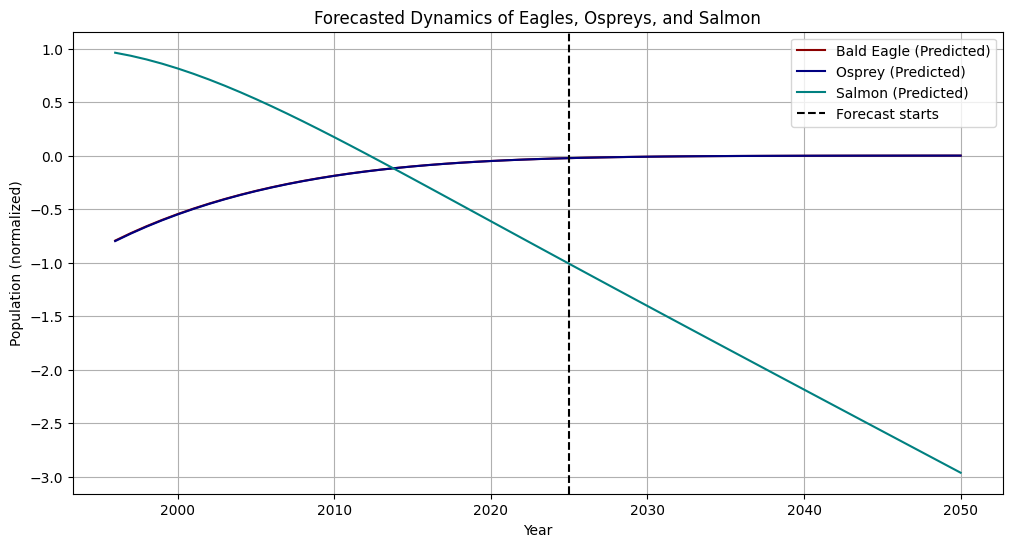

In [71]:

# Number of years you want to forecast into the future
future_years = 25  # Example: if last year is 2025, 25 years = up to 2050

# Extend the time points
last_time = time_points[-1].item()
future_time_points = torch.linspace(0, last_time + future_years, steps=len(time_points) + future_years)

# Use the trained model to predict the future
y0 = population_data[0]  # initial condition is the first observed data point
predicted_populations = torchdiffeq.odeint(ode_func, y0, future_time_points)

# Unnormalize if you want real units (optional — otherwise plotting normalized values)
eagle_pred = predicted_populations[:, 0].detach().numpy()
osprey_pred = predicted_populations[:, 1].detach().numpy()
salmon_pred = predicted_populations[:, 2].detach().numpy()

# Plotting
plt.figure(figsize=(12, 6))
years = np.arange(int(2025 - len(eagle_pop) + 1), 2025 + future_years + 1)  # adjust to your actual data range

plt.plot(years, eagle_pred, label="Bald Eagle (Predicted)", color='darkred')
plt.plot(years, osprey_pred, label="Osprey (Predicted)", color='navy')
plt.plot(years, salmon_pred, label="Salmon (Predicted)", color='teal')
plt.axvline(2025, color='black', linestyle='--', label="Forecast starts")  # Mark forecast starting point

plt.xlabel('Year')
plt.ylabel('Population (normalized)')
plt.title('Forecasted Dynamics of Eagles, Ospreys, and Salmon')
plt.legend()
plt.grid(True)
plt.show()


In [72]:
# After training finishes
death_rate = ode_func.d.item()
a_eagle = ode_func.a_eagle.item()
a_osprey = ode_func.a_osprey.item()

# R* calculation
R_star_eagle = death_rate / a_eagle
R_star_osprey = death_rate / a_osprey

print(f"R* Bald Eagle: {R_star_eagle:.4f}")
print(f"R* Osprey: {R_star_osprey:.4f}")

R* Bald Eagle: 3.6558
R* Osprey: 3.6396
